In [1]:
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as st
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import statsmodels.api as smt
import warnings

In [2]:
warnings.simplefilter('ignore')
rcParams['figure.figsize'] = 16, 6

# 导入数据

In [3]:
data = pd.read_csv('GDP_training.csv', parse_dates=['Time'], index_col='Time')
test = pd.read_csv('GDP_test.csv', parse_dates=['Time'], index_col='Time')

Text(0.5, 1.0, 'GDP')

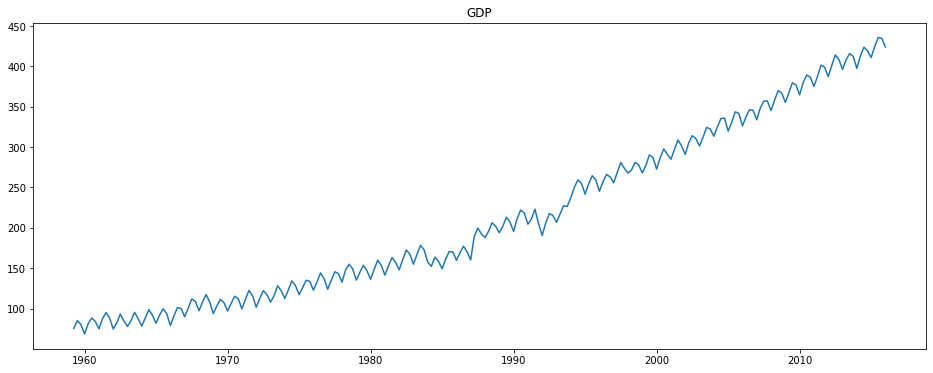

In [4]:
plt.figure()
plt.plot(data["GDP"])
plt.title("GDP")

# ARIMA 

## 选择 d

In [5]:
data_diff = data - data.shift()
data_diff.dropna(inplace=True)

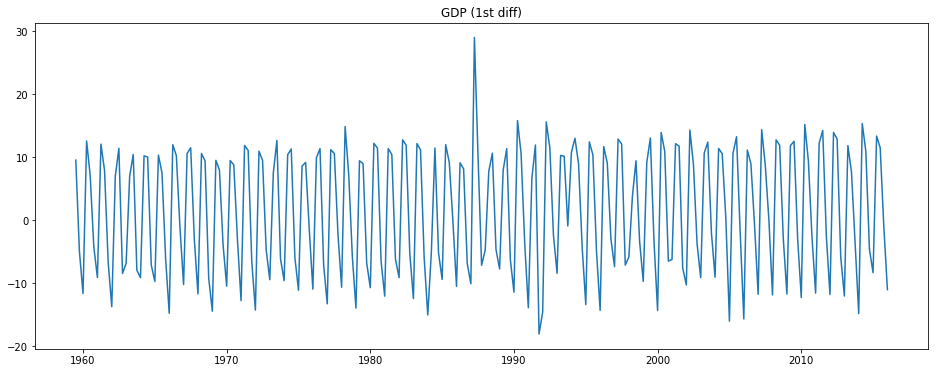

In [6]:
plt.figure()
plt.plot(data_diff)
plt.title("GDP (1st diff)");

**d = 1** 

### Ad-fuller test 

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
#Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print(dfoutput)

In [8]:
test_stationarity(data_diff["GDP"])

Results of Dickey-Fuller Test:
Test Statistic                  -3.031745
p-value                          0.032034
#Lags Used                      15.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


## 选择 p 和 q

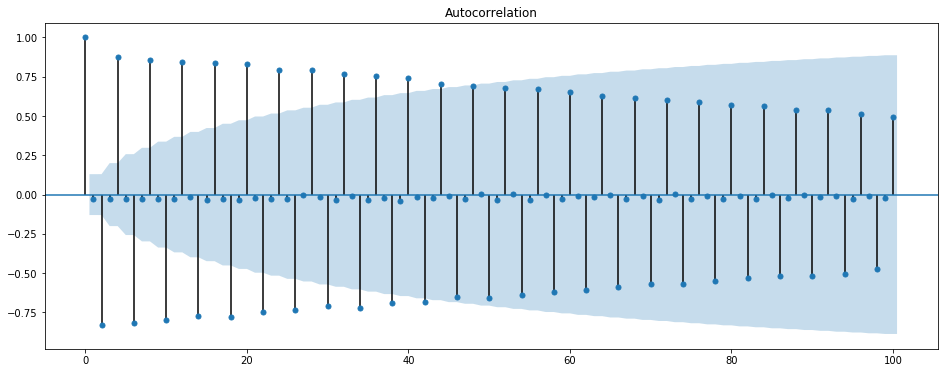

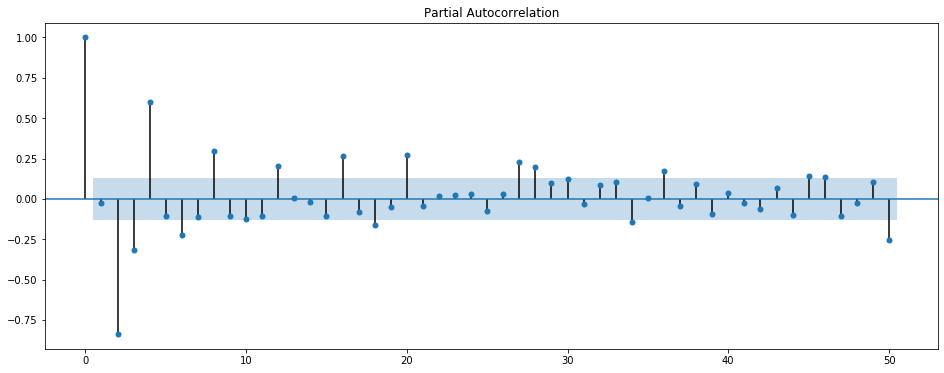

In [9]:
smt.graphics.tsa.plot_acf(data_diff, lags=100, alpha=0.05)
smt.graphics.tsa.plot_pacf(data_diff, lags=50, alpha=0.05);

In [10]:
# q = 44 
# p = 28

In [11]:
order = st.arma_order_select_ic(data_diff, max_ar = 10, max_ma = 10, ic=['aic'])
print(order.aic_min_order)

(4, 3)


In [12]:
p,q = order.aic_min_order

In [13]:
p = 4; q=3

## 用 train_set 训练 ARIMA 模型

In [14]:
training, testing = data[:-12], data[-12:] # split the data

model = ARIMA(training, order = (p, 1, q))  
results_AR = model.fit(disp = -1)

In [15]:
testing

,GDP
Time,
2013-03-31,408.141808
2013-06-30,415.808144
2013-09-30,412.281075
2013-12-31,397.465731
2014-03-31,412.836347
2014-06-30,423.798731
2014-09-30,419.179734
2014-12-31,410.870727
2015-03-31,424.248026


check the residual

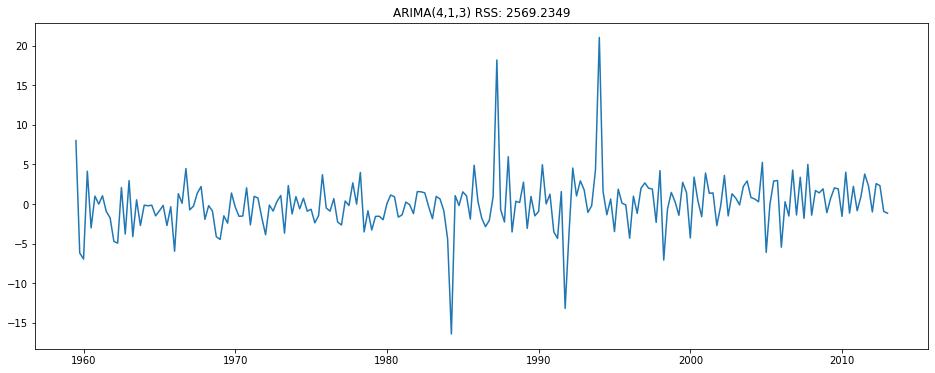

In [16]:
plt.figure() 
plt.plot(pd.DataFrame(results_AR.resid) )
plt.title('ARIMA(4,1,3) RSS: %.4f'% sum((results_AR.resid.values)**2)); # residual sum of square

## MSE评估拟合结果

In [17]:
validate = pd.DataFrame(results_AR.forecast(steps=12)[0],columns=["GDP"],index=testing.index)

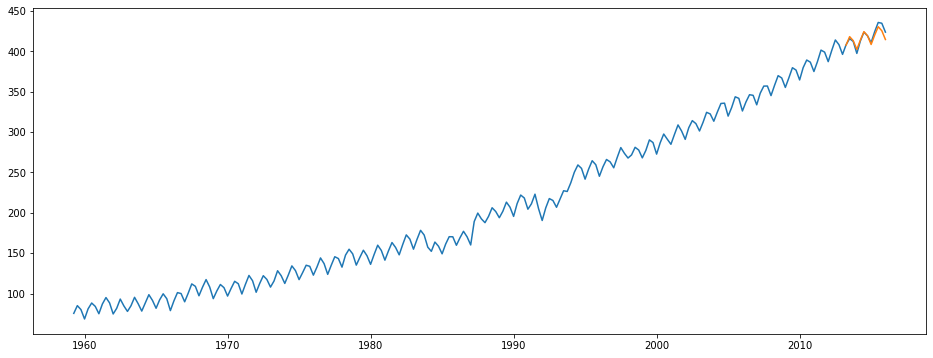

In [18]:
plt.figure()
plt.plot(data, label='Observed')
plt.plot(validate, label="validate")
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

print("MSE of train set for ARIMA\n{:.2f}".format(mean_squared_error(validate,testing)))

MSE of train set for ARIMA
21.07


## 用所有数据训练，预测结果

In [20]:
model = ARIMA(data, order = (p, 1, q))  
results_AR = model.fit(disp = -1)

In [21]:
pd.DataFrame(results_AR.forecast(steps=12)[0],columns=["GDP"],index=test.index)

,GDP
Time,
2016-03-31,435.481418
2016-06-30,445.956100
2016-09-30,441.018306
2016-12-31,430.136068
2017-03-31,441.793621
2017-06-30,452.270318
2017-09-30,447.335936
2017-12-31,436.452176
2018-03-31,448.105952


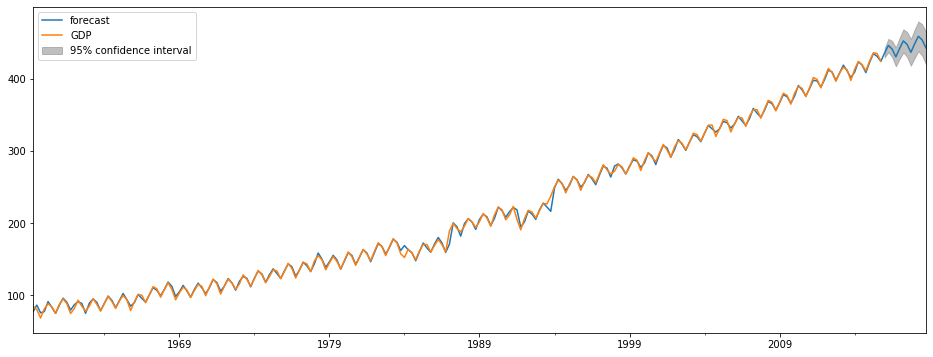

In [22]:
results_AR.plot_predict(start=str('1959-06-30'),end=str('2018-12-31'),dynamic = False);

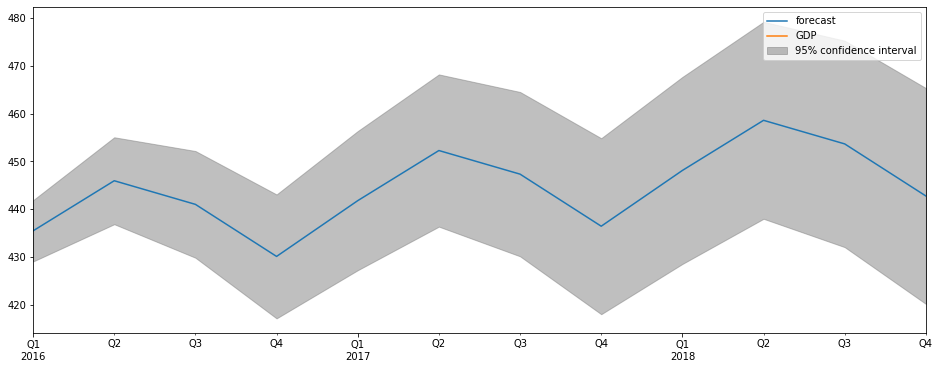

In [23]:
results_AR.plot_predict(start=str('2016-03-31'),end=str('2018-12-31'),dynamic = False);

# SARIMA

## 选择 PDQ

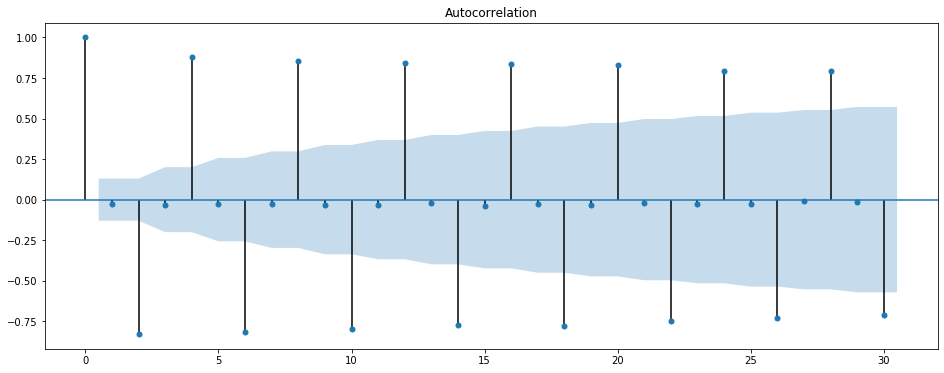

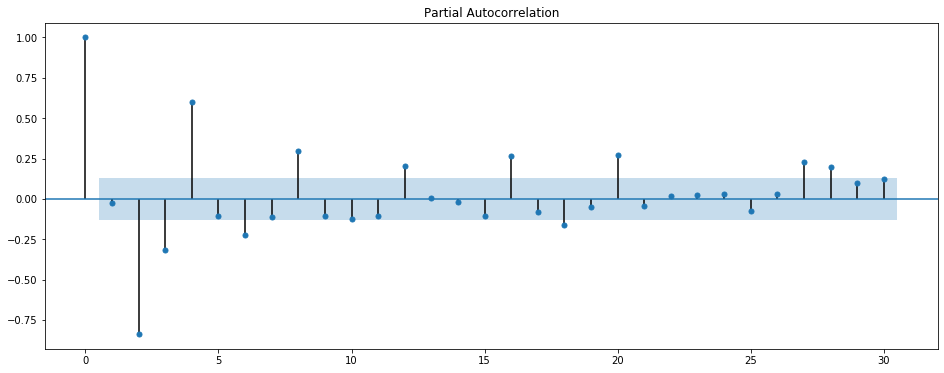

In [24]:
smt.graphics.tsa.plot_acf(data_diff, lags=30, alpha=0.05)
smt.graphics.tsa.plot_pacf(data_diff, lags=30, alpha=0.05);

In [25]:
P = D = Q = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [26]:
for param_seasonal in seasonal_pdq:

    mod = SARIMAX(data,
                  order=(p, 1, q),
                  seasonal_order=param_seasonal,
                  enforce_stationarity=False,
                  enforce_invertibility=False)

    results = mod.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format((p, 1, q), param_seasonal, results.aic))

ARIMA(4, 1, 3)x(0, 0, 0, 12)12 - AIC:1251.4399000014682
ARIMA(4, 1, 3)x(0, 0, 1, 12)12 - AIC:1192.1090633935878
ARIMA(4, 1, 3)x(0, 1, 0, 12)12 - AIC:1271.637652356927
ARIMA(4, 1, 3)x(0, 1, 1, 12)12 - AIC:1082.6417558175947
ARIMA(4, 1, 3)x(1, 0, 0, 12)12 - AIC:1195.711561733142
ARIMA(4, 1, 3)x(1, 0, 1, 12)12 - AIC:1153.7705615753898
ARIMA(4, 1, 3)x(1, 1, 0, 12)12 - AIC:1149.577697127285
ARIMA(4, 1, 3)x(1, 1, 1, 12)12 - AIC:1090.2361440440404


P = 0, D = 1, Q = 1

In [27]:
P = 0; D = 1; Q = 1

## 用 train_set 训练 SARIMA 模型

In [28]:
model = SARIMAX(training, 
                order=(4,1,3),             
                seasonal_order=(P,D,Q,4), 
                enforce_stationarity=False,
                enforce_invertibility=False) 

results = model.fit(disp = -1)

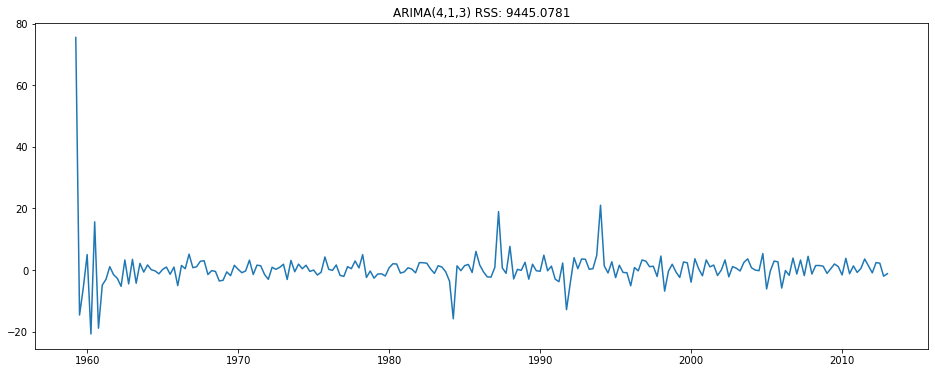

In [29]:
plt.figure() 
plt.plot(pd.DataFrame(results.resid))
plt.title('ARIMA(4,1,3) RSS: %.4f'% sum((results.resid.values)**2)); # residual sum of square

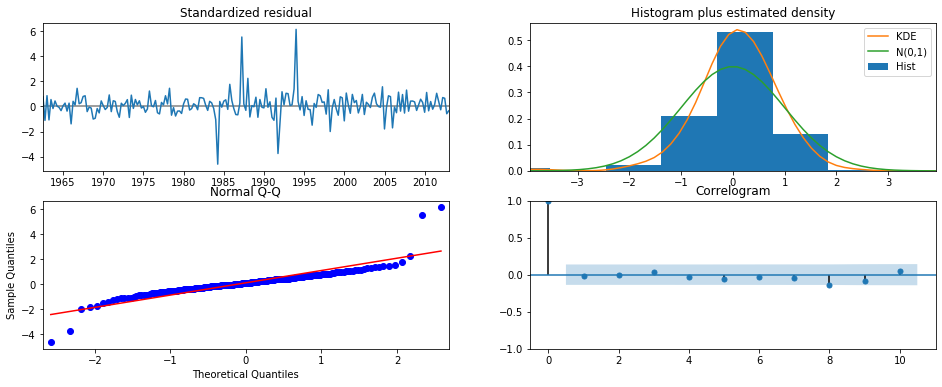

In [30]:
results.plot_diagnostics();

## MSE 评估拟合结果

In [31]:
validate = results.forecast(len(testing))

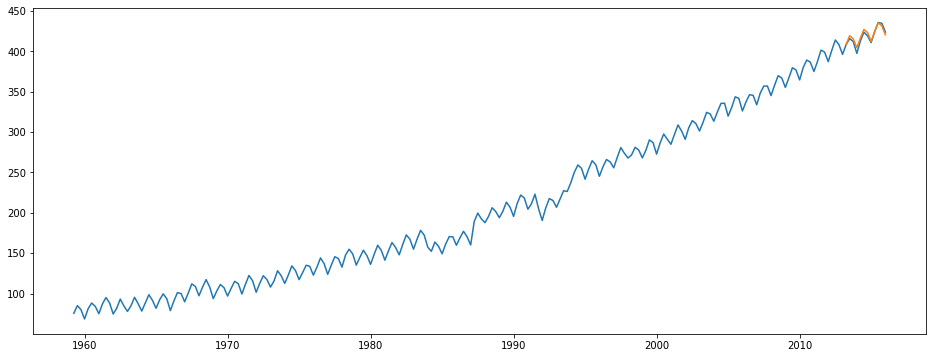

In [32]:
plt.figure()
plt.plot(data,label='Observed')
plt.plot(validate, label="validate")
plt.show(); 

In [33]:
print("MSE of train set for SARIMA\n{:.2f}".format(mean_squared_error(validate, testing)))

MSE of train set for SARIMA
11.62


## 用所有数据训练模型，预测结果

In [34]:
model = SARIMAX(data, 
                order=(4,1,3),             
                seasonal_order=(P,D,Q,4), 
                enforce_stationarity=False,
                enforce_invertibility=False) 

results = model.fit(disp = -1)

In [35]:
forecast = results.forecast(len(testing))
forecast

2016-03-31    436.073411
2016-06-30    446.942172
2016-09-30    443.253042
2016-12-31    432.224121
2017-03-31    444.601015
2017-06-30    455.528841
2017-09-30    451.932942
2017-12-31    440.834243
2018-03-31    453.158974
2018-06-30    464.077174
2018-09-30    460.516247
2018-12-31    449.440286
Freq: Q-DEC, dtype: float64

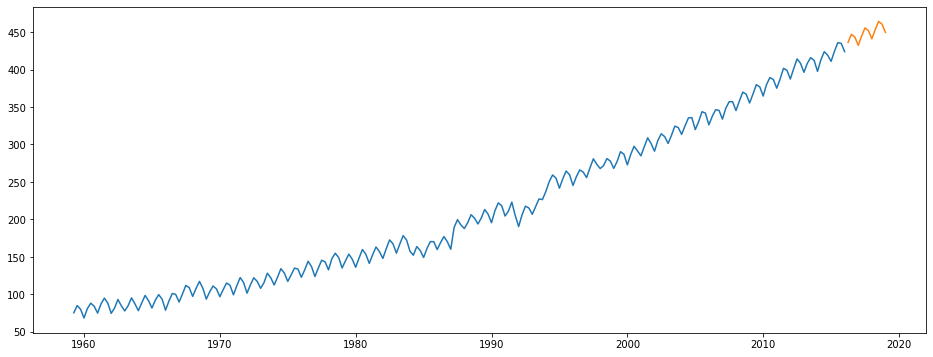

In [36]:
plt.figure()
plt.plot(data, label='Observed')
plt.plot(forecast, label="validate")
plt.show()